In [1]:
import os

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_eeg_topomaps
from scipy.stats import zscore
from tqdm import tqdm
from utils import run_in_parallel

plt.style.use("papers")

DATA_FOLDER = "../../data/test_data_LEMON/"
RESULTS_FOLDER = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20220728_VARprocess_EC_allsubjects_30.0s_segment_1200.0s_VARlength"

# VAR orders

In [2]:
orders_raw = pd.read_csv(os.path.join(RESULTS_FOLDER, "VAR_orders_aic.csv"))
orders = []
for col in orders_raw.filter(like="sub"):
    orders.append(orders_raw[["order", col]].dropna(axis=0).set_index("order"))
orders = pd.concat(orders, axis=1)

mins = orders.idxmin()
display(mins)
display(mins.median(), mins.mean())

sub-010072_EC    10
sub-010069_EC    10
sub-010068_EC    10
sub-010074_EC    10
sub-010070_EC    10
                 ..
sub-010060_EC    10
sub-010061_EC    10
sub-010062_EC    10
sub-010063_EC    10
sub-010064_EC    10
Length: 203, dtype: int64

10.0

9.650246305418719

<AxesSubplot:xlabel='order', ylabel='AIC'>

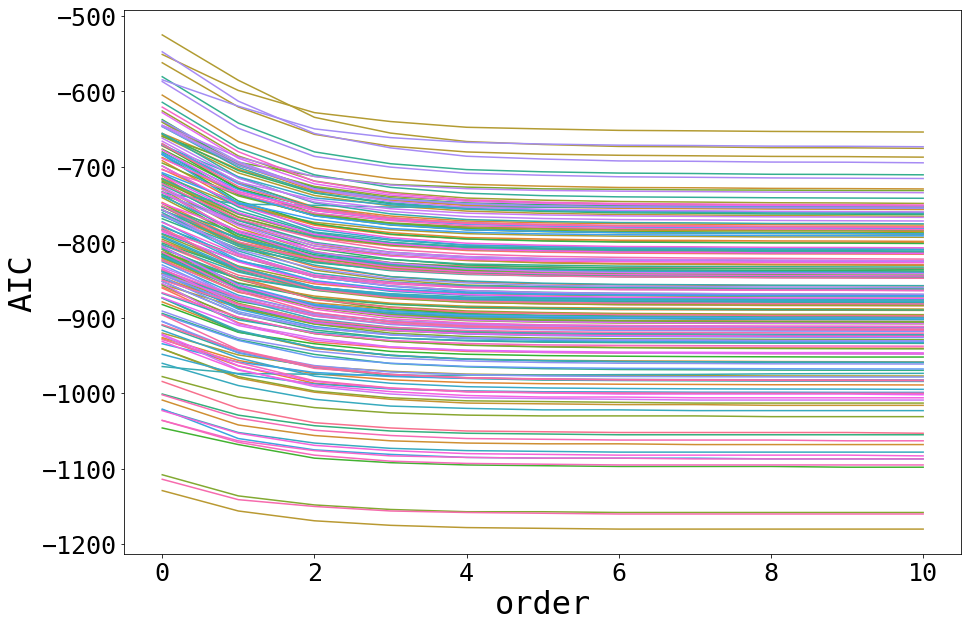

In [3]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=orders.reset_index().melt(
        id_vars="order", value_name="AIC", var_name="subject"
    ),
    x="order",
    y="AIC",
    hue="subject",
    legend=False,
)

# Topomaps

In [4]:
topomaps = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps.nc"))
topomaps = topomaps.set_index({"stack": ["subject_id", "type"]}).unstack()

/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_67460/2980343528.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_67460/2980343528.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False


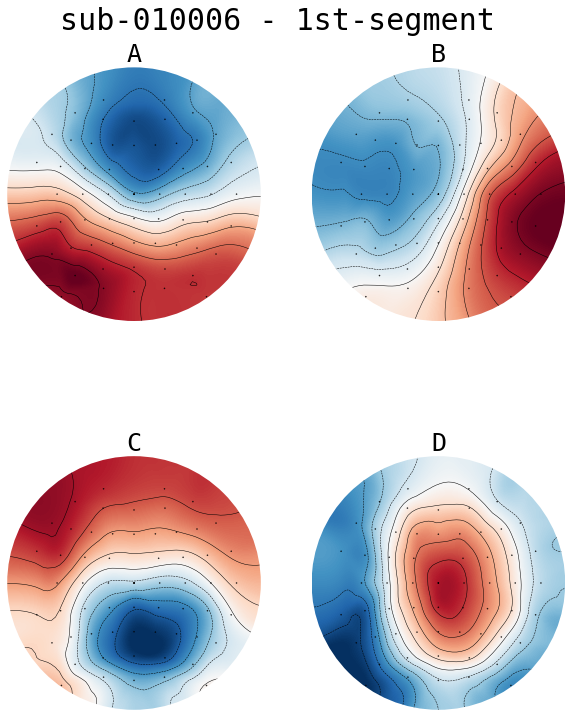

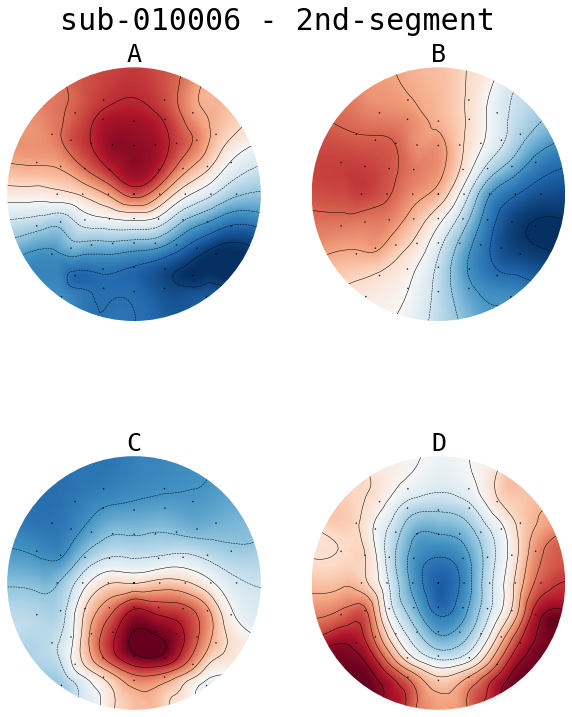

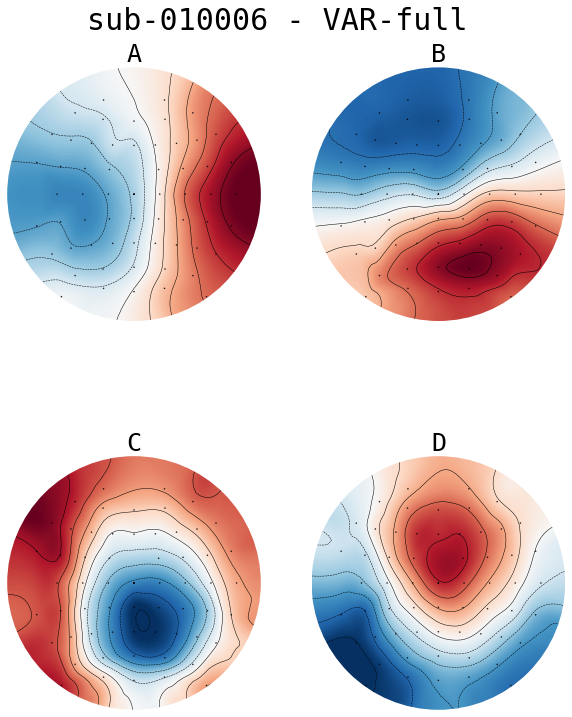

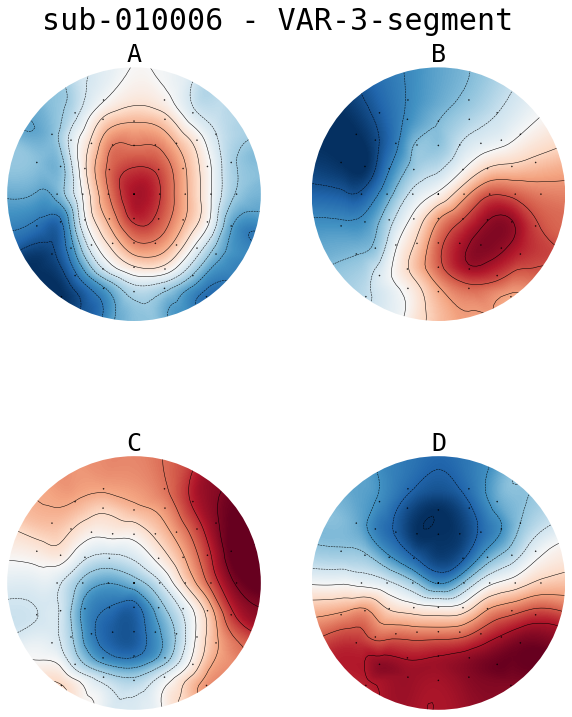

In [5]:
subj_id = "sub-010006"
subj_info = mne.io.read_raw_eeglab(
    os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
)
PLOT_TYPES = ["1st-segment", "2nd-segment", "VAR-full", "VAR-3-segment"]

for plot_type in PLOT_TYPES:
    plot_eeg_topomaps(
        topomaps.sel({"subject_id": subj_id, "type": plot_type})
        .dropna("channels")
        .values,
        subj_info.info,
        title=subj_id + " - " + plot_type,
    )
    plt.show()

# Topomaps accordance

In [6]:
combined = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps_corrs.nc"))
SUBJECTS = list(combined["subj1"].values)

In [7]:
# reflect those matrices
stack_coords = ["latent map", "type1", "type2"]
reflected = []
for coords, dtarray in tqdm(combined.stack(all=stack_coords).groupby("all")):
    refl = np.triu(dtarray, k=1).T + np.nan_to_num(dtarray)
    refl = xr.DataArray(refl, dims=dtarray.dims, coords=dtarray.coords)
    refl = refl.assign_coords({k: v for k, v in zip(stack_coords, coords)}).expand_dims(
        stack_coords
    )
    reflected.append(refl)
reflected = xr.combine_by_coords(reflected).drop_vars("all")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7396/7396 [00:21<00:00, 344.54it/s]


In [8]:
var_mean = (
    reflected.isel({"type1": reflected["type1"].str.match("VAR-.*-segment")})
    .sel({"type2": "2nd-segment"})
    .mean("type1")
    .assign_coords({"type1": "VAR-segment-mean"})
    .expand_dims(["type1", "type2"])
)
combined = xr.concat([reflected, var_mean], dim="type1")

In [9]:
combined

<xarray.DataArray (latent map: 4, type1: 44, type2: 43, subj1: 203, subj2: 203)>
array([[[[[1.00000000e+00, 4.24907191e-01, 2.43283800e-02, ...,
           1.28195891e-01, 1.40020716e-01, 3.39645769e-01],
          [4.24907191e-01, 1.00000000e+00, 2.96475301e-01, ...,
           7.71034025e-01, 8.60321406e-01, 5.52932352e-01],
          [2.43283800e-02, 2.96475301e-01, 1.00000000e+00, ...,
           5.19013708e-01, 2.84197801e-01, 5.55403498e-01],
          ...,
          [1.28195891e-01, 7.71034025e-01, 5.19013708e-01, ...,
           1.00000000e+00, 7.28850617e-01, 5.86449078e-01],
          [1.40020716e-01, 8.60321406e-01, 2.84197801e-01, ...,
           7.28850617e-01, 1.00000000e+00, 3.01661874e-01],
          [3.39645769e-01, 5.52932352e-01, 5.55403498e-01, ...,
           5.86449078e-01, 3.01661874e-01, 1.00000000e+00]],

         [[7.87811059e-01, 6.90026104e-01, 1.18656943e-01, ...,
           2.07011234e-01, 7.20978997e-01, 2.81303985e-01],
          [6.90026104e-01, 6.46378107e-01, 4.30788731e-01, ...,
           8.36488778e-01, 4.69137652e-01, 6.92588284e-01],
          [1.18656943e-01, 4.30788731e-01, 9.26512129e-01, ...,
           4.23021583e-01, 2.24024505e-02, 4.69004906e-01],
...
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan]],

         [[           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          ...,
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan]]]]])
Coordinates:
  * type2       (type2) <U14 '1st-segment' '2nd-segment' ... 'VAR-full'
  * subj1       (subj1) object 'sub-010002' 'sub-010003' ... 'sub-010321'
  * subj2       (subj2) object 'sub-010002' 'sub-010003' ... 'sub-010321'
  * latent map  (latent map) <U1 'A' 'B' 'C' 'D'
  * type1       (type1) <U16 '1st-segment' '2nd-segment' ... 'VAR-segment-mean'

Text(232.07710997442462, 0.5, 'seg. VAR $\\to$ 2nd seg.')

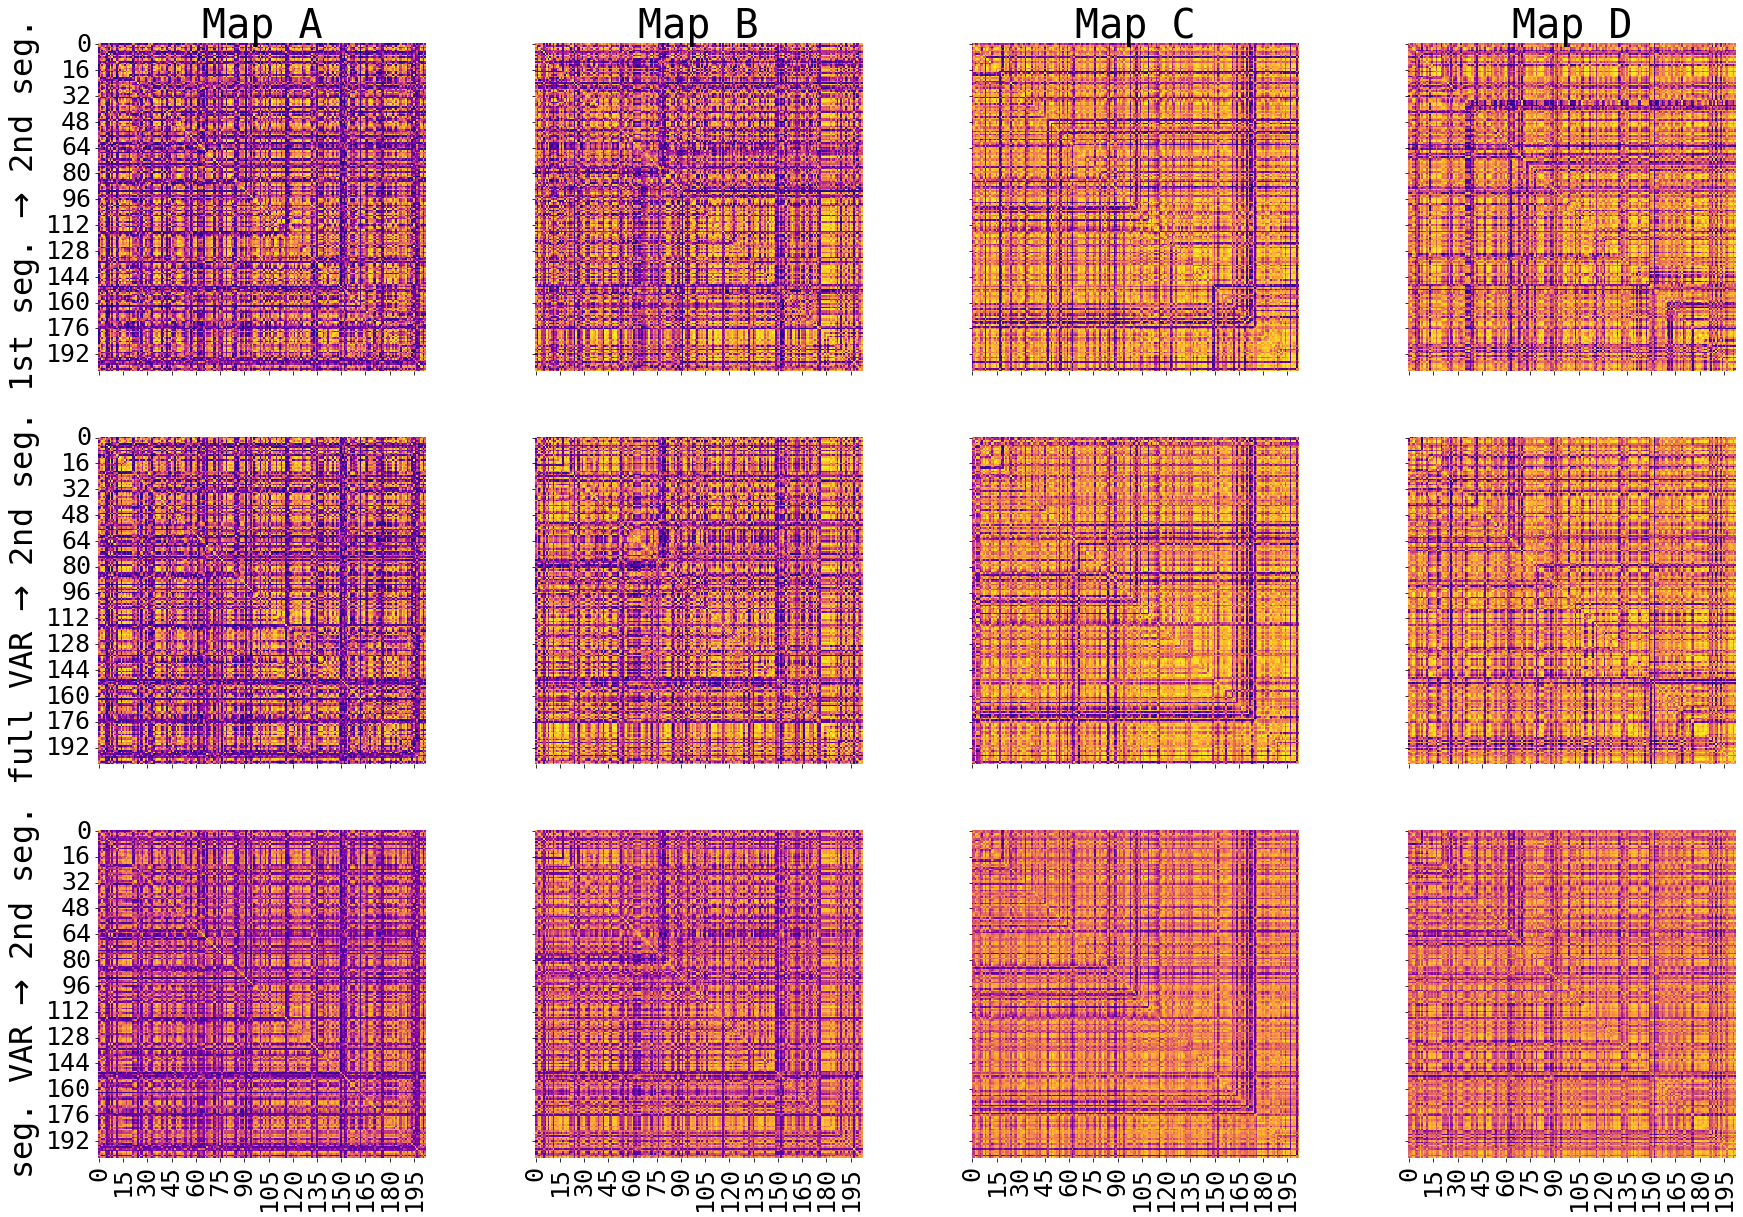

In [10]:
fig, axs = plt.subplots(
    nrows=3, ncols=4, squeeze=True, figsize=(30, 20.5), sharey=True, sharex=True
)

for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full", "VAR-segment-mean"]):
        sns.heatmap(
            combined.sel({"type1": howto, "type2": "2nd-segment", "latent map": lamap}),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="plasma",
            vmin=0,
            vmax=1,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")
axs[2, 0].set_ylabel(r"seg. VAR $\to$ 2nd seg.")

Text(232.07710997442462, 0.5, 'seg. VAR $\\to$ 2nd seg.')

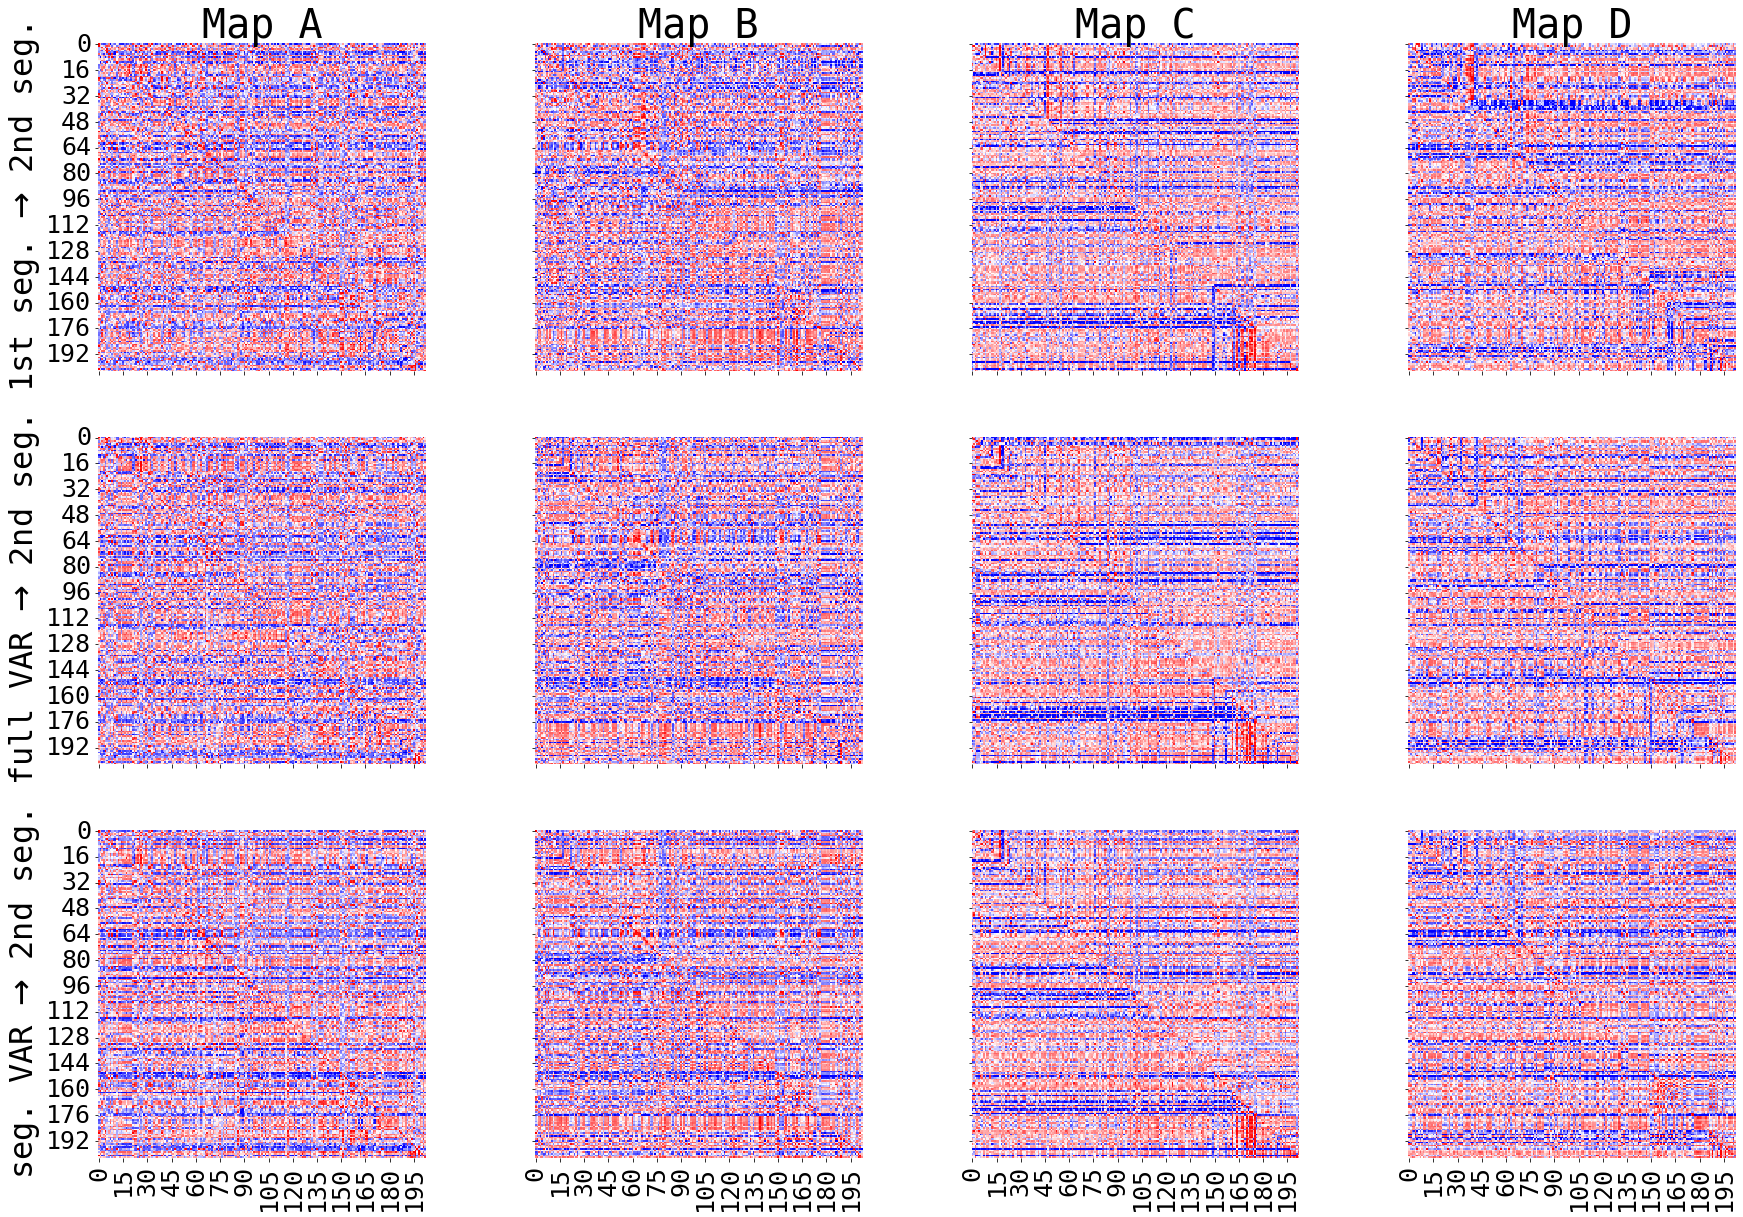

In [11]:
fig, axs = plt.subplots(
    nrows=3, ncols=4, squeeze=True, figsize=(30, 20.5), sharey=True, sharex=True
)
for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full", "VAR-segment-mean"]):
        sns.heatmap(
            zscore(
                combined.sel(
                    {"type1": howto, "type2": "2nd-segment", "latent map": lamap}
                ).values,
                axis=0,
            ),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="bwr",
            vmin=-2.0,
            vmax=2.0,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")
axs[2, 0].set_ylabel(r"seg. VAR $\to$ 2nd seg.")

In [12]:
correct_classif = pd.DataFrame(
    columns=list(combined["latent map"].values),
    index=["1st-segment", "VAR-full", "VAR-segment-mean"],
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full", "VAR-segment-mean"]:
        correct_classif.loc[howto, str(lamap.values)] = (
            combined.sel(
                {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
            ).values.argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif)

correct_classif_zs = pd.DataFrame(
    columns=list(combined["latent map"].values),
    index=["1st-segment", "VAR-full", "VAR-segment-mean"],
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full", "VAR-segment-mean"]:
        correct_classif_zs.loc[howto, str(lamap.values)] = (
            zscore(
                combined.sel(
                    {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
                ).values,
                axis=0,
            ).argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif_zs)

A   B   C   D
1st-segment       50  40  41  43
VAR-full          60  56  50  49
VAR-segment-mean  60  45  33  35

A   B   C   D
1st-segment       50  40  41  43
VAR-full          60  56  50  49
VAR-segment-mean  60  45  33  35

# Static and dynamic stats

In [13]:
static_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "static_stats.csv"), index_col=0
)
static_stats[["subject_id", "type"]] = (
    static_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
static_stats = static_stats.drop(
    ["filter", "decomposition_type", "use_gfp", "no_states"], axis=1
).sort_values(["subject_id", "type", "latent map"])
# make mean / std from VAR segments
var_means = (
    static_stats.loc[static_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id", "latent map"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

static_stats_final = pd.concat(
    [static_stats.loc[~static_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
static_stats_final = static_stats_final.set_index(["subject_id", "type", "latent map"])
static_stats_final

var_GFP  var_total  template_corr  \
subject_id type              latent map                                       
sub-010002 1st-segment       A           0.667725   0.605779       0.689887   
                             B           0.667725   0.605779       0.969057   
                             C           0.667725   0.605779       0.682622   
                             D           0.667725   0.605779       0.650335   
           2nd-segment       A           0.686003   0.620166       0.961467   
...                                           ...        ...            ...   
sub-010319 VAR-segments-mean D           0.763097   0.706097       0.792267   
sub-010321 VAR-segments-mean A           0.854105   0.795720       0.852350   
                             B           0.854105   0.795720       0.866670   
                             C           0.854105   0.795720       0.885959   
                             D           0.854105   0.795720       0.916821   

                                         coverage  occurrence   lifespan  \
subject_id type              latent map                                    
sub-010002 1st-segment       A           0.277430   19.097454  14.520070   
                             B           0.235702   17.964271  13.120594   
                             C           0.215838   15.164645  14.232967   
                             D           0.271031   18.930809  14.335097   
           2nd-segment       A           0.277030   18.364218  15.085299   
...                                           ...         ...        ...   
sub-010319 VAR-segments-mean D           0.247435   13.416596  18.467548   
sub-010321 VAR-segments-mean A           0.247508   14.510613  17.046485   
                             B           0.251157   14.588938  17.196633   
                             C           0.242775   14.423128  16.821316   
                             D           0.258560   14.374799  17.982357   

                                         transition->A  transition->B  \
subject_id type              latent map                                 
sub-010002 1st-segment       A                0.724519       0.091827   
                             B                0.116516       0.695136   
                             C                0.096973       0.085855   
                             D                0.103788       0.102804   
           2nd-segment       A                0.734841       0.070260   
...                                                ...            ...   
sub-010319 VAR-segments-mean D                0.069356       0.073951   
sub-010321 VAR-segments-mean A                0.761501       0.081203   
                             B                0.077977       0.762670   
                             C                0.078247       0.085967   
                             D                0.078045       0.071558   

                                         transition->C  transition->D  
subject_id type              latent map                                
sub-010002 1st-segment       A                0.089423       0.094231  
                             B                0.068439       0.119910  
                             C                0.718962       0.098209  
                             D                0.072799       0.720610  
           2nd-segment       A                0.071704       0.123195  
...                                                ...            ...  
sub-010319 VAR-segments-mean D                0.074396       0.782297  
sub-010321 VAR-segments-mean A                0.080344       0.076952  
                             B                0.077495       0.081858  
                             C                0.756909       0.078877  
                             D                0.074581       0.775816  

[3248 rows x 10 columns]

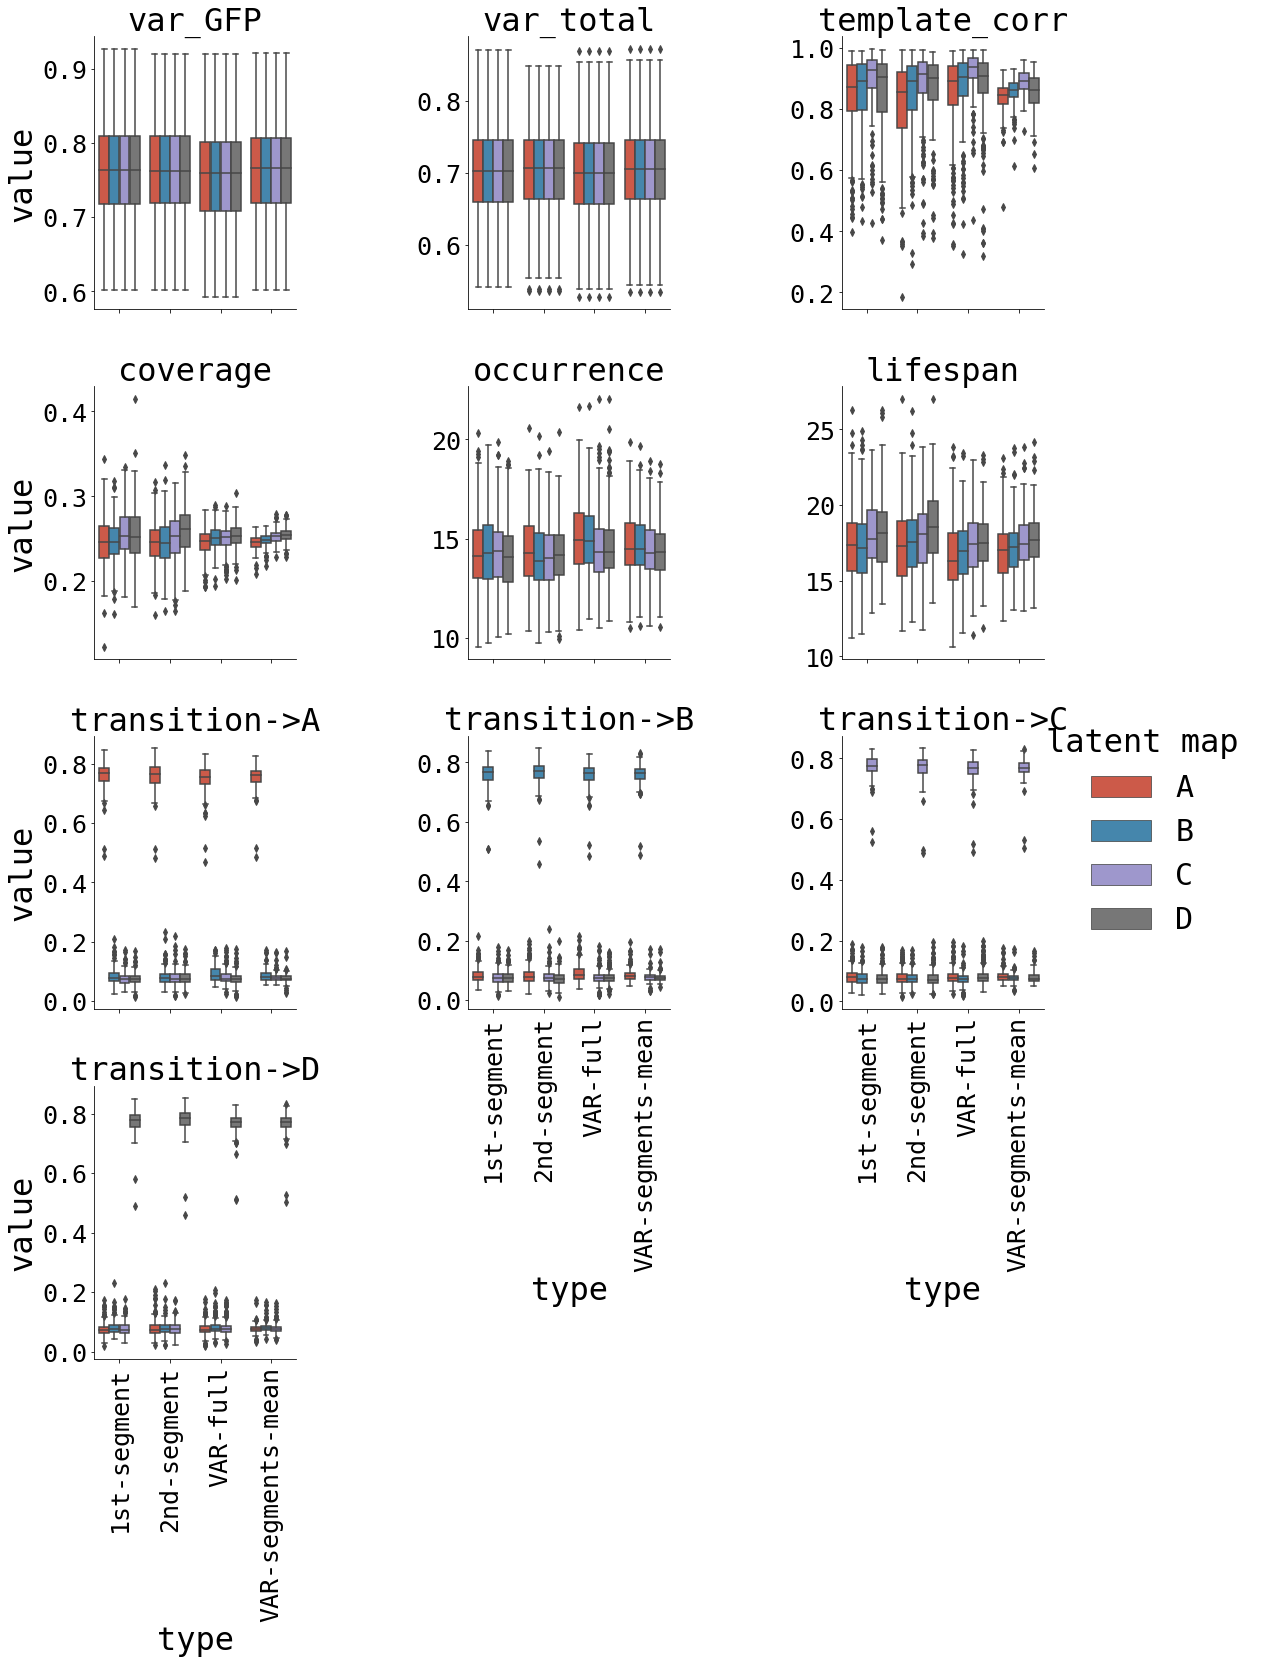

In [14]:
melt = static_stats_final.reset_index().melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
        "transition->A",
        "transition->B",
        "transition->C",
        "transition->D",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [15]:
static_stats_final["template_corr"].groupby(["type", "latent map"]).agg(
    ["mean", "median"]
)

mean    median
type              latent map                    
1st-segment       A           0.838208  0.873098
                  B           0.852559  0.891932
                  C           0.897477  0.927520
                  D           0.847215  0.904991
2nd-segment       A           0.815434  0.855046
                  B           0.848553  0.889605
                  C           0.877590  0.914828
                  D           0.865105  0.902369
VAR-full          A           0.848479  0.890378
                  B           0.872130  0.905610
                  C           0.918542  0.936836
                  D           0.871285  0.909002
VAR-segments-mean A           0.837674  0.845043
                  B           0.855076  0.860296
                  C           0.889422  0.892129
                  D           0.856039  0.863255

In [16]:
STATS_COLS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition->A",
    "transition->B",
    "transition->C",
    "transition->D",
]

real_data_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "1st-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
) ** 2

var_full_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "VAR-full"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
) ** 2

all_segments = sorted(
    static_stats["type"][static_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        static_stats[static_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
        - static_stats[static_stats["type"] == segment]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
    ) ** 2
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id", "latent map"]).mean()
)

df1 = static_stats_final.reset_index()
var_mean_segments = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - df1[df1["type"] == "VAR-segments-mean"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
) ** 2

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_mean_segments["diffs"] = "VAR-segments-mean"
static_diffs = pd.concat(
    [real_data_diff, var_full_diff, var_mean_segments]
).reset_index()

In [17]:
SIMPLE_MEAN = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
]

TRANS = ["transition->A", "transition->B", "transition->C", "transition->D"]

simple_means = static_diffs.groupby(["subject_id", "diffs"])[SIMPLE_MEAN].mean()
trans_means = (
    static_diffs.groupby(["subject_id", "diffs"])[TRANS]
    .mean()
    .reset_index()
    .melt(id_vars=["subject_id", "diffs"])
    .groupby(["subject_id", "diffs"])["value"]
    .mean()
)
trans_means.name = "transition_matrix"
static_diffs = pd.concat([simple_means, trans_means], axis=1).reset_index()

In [18]:
DVS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition_matrix",
]
static_ts = []

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=static_diffs, dv=dv, within="diffs", subject="subject_id"))
    ttests = pg.pairwise_ttests(
        data=static_diffs,
        dv=dv,
        within="diffs",
        subject="subject_id",
        padjust="fdr_by",
    )
    display(ttests)
    ttests["var"] = dv
    static_ts.append(ttests)
    
static_ts = pd.concat(static_ts)
static_ts.to_csv(os.path.join(RESULTS_FOLDER, "static_ttest.csv"))

== var_GFP ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2         F     p-unc       ng2       eps
0  diffs      2    404  5.048899  0.006827  0.000599  0.915757

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative     p-unc    p-corr p-adjust   BF10    hedges  
0  2.846123  202.0   two-sided  0.004882  0.013425   fdr_by  3.942  0.052645  
1 -0.002823  202.0   two-sided  0.997750  1.000000   fdr_by  0.078 -0.000059  
2 -3.124354  202.0   two-sided  0.002044  0.011242   fdr_by   8.64 -0.052235

== var_total ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2         F     p-unc       ng2       eps
0  diffs      2    404  5.185901  0.005973  0.000361  0.837861

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative     p-unc    p-corr p-adjust   BF10    hedges  
0  3.150826  202.0   two-sided  0.001875  0.010315   fdr_by  9.343  0.045864  
1  1.535859  202.0   two-sided  0.126138  0.231253   fdr_by  0.249  0.025376  
2 -1.836138  202.0   two-sided  0.067807  0.186470   fdr_by  0.408 -0.020965

== template_corr ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2          F         p-unc       ng2       eps
0  diffs      2    404  34.608351  1.339377e-14  0.051481  0.810895

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  6.792003  202.0   two-sided  1.210176e-10  3.327984e-10   fdr_by   
1 -2.107509  202.0   two-sided  3.630703e-02  6.656288e-02   fdr_by   
2 -8.803486  202.0   two-sided  5.992290e-16  3.295760e-15   fdr_by   

        BF10    hedges  
0   6.36e+07  0.412815  
1      0.685 -0.155565  
2  9.305e+12 -0.589377

== coverage ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2          F         p-unc      ng2       eps
0  diffs      2    404  31.804331  1.488542e-13  0.05156  0.603812

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  6.417110  202.0   two-sided  9.690990e-10  2.665022e-09   fdr_by   
1 -3.902729  202.0   two-sided  1.295515e-04  2.375111e-04   fdr_by   
2 -7.194823  202.0   two-sided  1.198884e-11  6.593863e-11   fdr_by   

        BF10    hedges  
0  8.499e+06  0.258627  
1    109.769 -0.317132  
2  5.986e+08 -0.536451

== occurrence ==


Source  ddof1  ddof2          F         p-unc     p-GG-corr      ng2  \
0  diffs      2    404  21.280633  1.633292e-09  5.947675e-08  0.03135   

        eps  sphericity  W-spher       p-spher  
0  0.784511       False  0.72532  9.621032e-15

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  6.537851  202.0   two-sided  4.997670e-10  2.748719e-09   fdr_by   
1  1.010987  202.0   two-sided  3.132323e-01  5.742591e-01   fdr_by   
2 -6.302084  202.0   two-sided  1.808265e-09  4.972730e-09   fdr_by   

        BF10    hedges  
0  1.612e+07  0.399415  
1       0.13  0.073353  
2  4.653e+06 -0.416249

== lifespan ==


Source  ddof1  ddof2          F         p-unc     p-GG-corr     ng2  \
0  diffs      2    404  22.366717  6.128769e-10  3.274728e-08  0.0239   

        eps  sphericity   W-spher       p-spher  
0  0.774242       False  0.708414  8.992625e-16

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  8.254814  202.0   two-sided  1.956189e-14  1.075904e-13   fdr_by   
1  0.107360  202.0   two-sided  9.146098e-01  1.000000e+00   fdr_by   
2 -5.548726  202.0   two-sided  8.962225e-08  2.464612e-07   fdr_by   

        BF10    hedges  
0  3.093e+11  0.348904  
1      0.079  0.006769  
2  1.088e+05 -0.342448

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


== transition_matrix ==


Source  ddof1  ddof2          F         p-unc       ng2       eps
0  diffs      2    404  25.953758  2.488468e-11  0.022851  0.882488

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  6.464303  202.0   two-sided  7.487682e-10  2.059112e-09   fdr_by   
1  0.656157  202.0   two-sided  5.124695e-01  9.395275e-01   fdr_by   
2 -7.138253  202.0   two-sided  1.666350e-11  9.164925e-11   fdr_by   

        BF10    hedges  
0   1.09e+07  0.348156  
1      0.097  0.035183  
2  4.349e+08 -0.330506

In [19]:
dynamic_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "dynamic_stats.csv"), index_col=0
)
dynamic_stats[["subject_id", "type"]] = (
    dynamic_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
dynamic_stats = dynamic_stats.sort_values(["subject_id", "type"])
# make mean / std from VAR segments
var_means = (
    dynamic_stats.loc[dynamic_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

dynamic_stats_final = pd.concat(
    [dynamic_stats.loc[~dynamic_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
dynamic_stats_final = dynamic_stats_final.set_index(["subject_id", "type"])
dynamic_stats_final

mixing time   entropy  max entropy  \
subject_id type                                                    
sub-010002 1st-segment           2.758280  1.992529          2.0   
           2nd-segment           2.720878  1.990716          2.0   
           VAR-full              2.763139  1.999563          2.0   
sub-010003 1st-segment           4.201763  1.984589          2.0   
           2nd-segment           3.925516  1.965716          2.0   
...                                   ...       ...          ...   
sub-010316 VAR-segments-mean     3.838225  1.988222          2.0   
sub-010317 VAR-segments-mean     3.570236  1.990738          2.0   
sub-010318 VAR-segments-mean     3.023268  1.988340          2.0   
sub-010319 VAR-segments-mean     3.655338  1.990519          2.0   
sub-010321 VAR-segments-mean     3.508965  1.986235          2.0   

                              entropy_rate  MC entropy rate  AIF 1st peak  
subject_id type                                                            
sub-010002 1st-segment            1.236732         1.307951          52.0  
           2nd-segment            1.248167         1.316629          80.0  
           VAR-full               1.289160         1.329780          80.0  
sub-010003 1st-segment            0.997050         1.037051          52.0  
           2nd-segment            0.964161         1.004707          56.0  
...                                    ...              ...           ...  
sub-010316 VAR-segments-mean      1.016042         1.065411          52.1  
sub-010317 VAR-segments-mean      1.079570         1.142636          52.1  
sub-010318 VAR-segments-mean      1.177783         1.254799          44.0  
sub-010319 VAR-segments-mean      1.051106         1.100786          51.7  
sub-010321 VAR-segments-mean      1.090667         1.141034          49.8  

[812 rows x 6 columns]

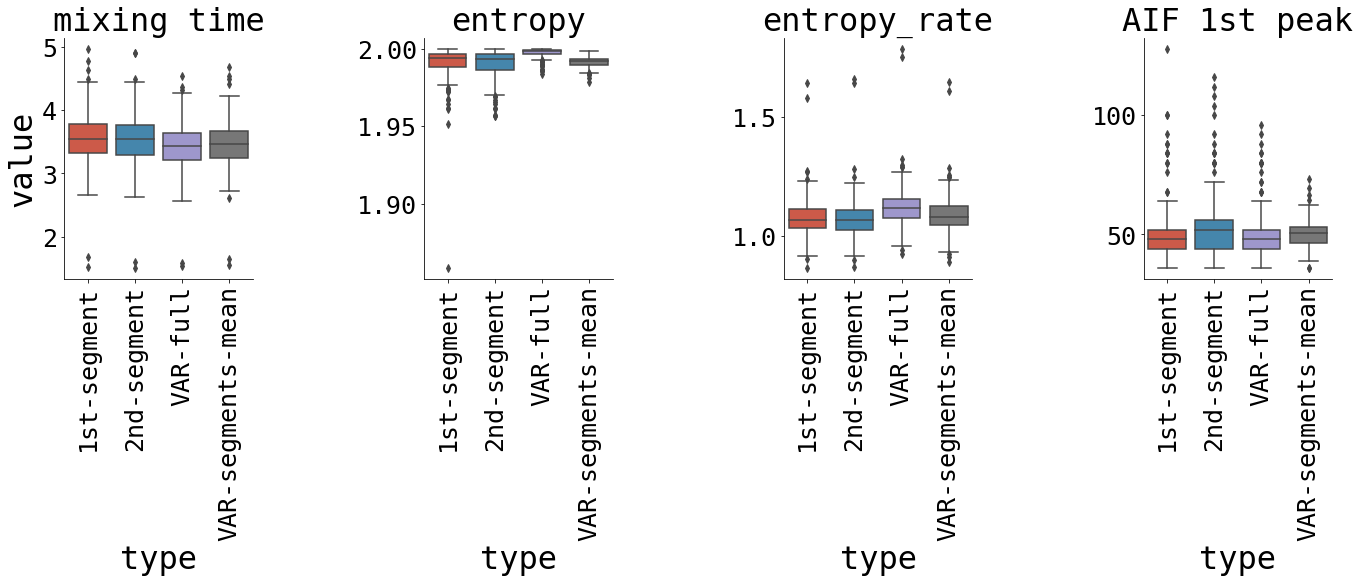

In [20]:
g = sns.catplot(
    data=dynamic_stats_final.reset_index().melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=4,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [21]:
dynamic_stats

subject_id  mixing time   entropy  max entropy  entropy_rate  \
0   sub-010002     2.758280  1.992529          2.0      1.236732   
0   sub-010002     2.720878  1.990716          2.0      1.248167   
0   sub-010002     2.736983  1.994533          2.0      1.229122   
0   sub-010002     2.755911  1.994064          2.0      1.237818   
0   sub-010002     2.738067  1.999085          2.0      1.272612   
..         ...          ...       ...          ...           ...   
0   sub-010321     3.656517  1.947636          2.0      1.077574   
0   sub-010321     3.282357  1.998036          2.0      1.090537   
0   sub-010321     3.779563  1.986086          2.0      1.083101   
0   sub-010321     3.476375  1.991741          2.0      1.096539   
0   sub-010321     3.373367  1.992130          2.0      1.115590   

    MC entropy rate  AIF 1st peak            type  
0          1.307951          52.0     1st-segment  
0          1.316629          80.0     2nd-segment  
0          1.293765          72.0   VAR-1-segment  
0          1.297540          68.0  VAR-10-segment  
0          1.338153          52.0  VAR-11-segment  
..              ...           ...             ...  
0          1.129154          48.0   VAR-6-segment  
0          1.142362          48.0   VAR-7-segment  
0          1.129805          52.0   VAR-8-segment  
0          1.148895          48.0   VAR-9-segment  
0          1.143653          52.0        VAR-full  

[8729 rows x 8 columns]

In [22]:
STATS_COLS = [
    "mixing time",
    "entropy",
    "entropy_rate",
    "AIF 1st peak",
]

real_data_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "1st-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
) ** 2

var_full_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "VAR-full"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
) ** 2

all_segments = sorted(
    dynamic_stats["type"][dynamic_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
        - dynamic_stats[dynamic_stats["type"] == segment]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
    ) ** 2
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = all_segments_diffs.reset_index().groupby(["subject_id"]).mean()

df1 = dynamic_stats_final.reset_index()
var_mean_segments = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - df1[df1["type"] == "VAR-segments-mean"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
) ** 2

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_mean_segments["diffs"] = "VAR-segments-mean"
dynamic_diffs = pd.concat(
    [real_data_diff, var_full_diff, var_mean_segments]
).reset_index()

In [23]:
dynamic_diffs

subject_id  mixing time       entropy  entropy_rate  AIF 1st peak  \
0    sub-010002     0.001399  3.287873e-06      0.000131        784.00   
1    sub-010003     0.076312  3.561914e-04      0.001082         16.00   
2    sub-010004     0.056910  6.194082e-06      0.001413         16.00   
3    sub-010005     0.042356  2.536602e-04      0.000673         16.00   
4    sub-010006     0.000593  6.751928e-07      0.000491         64.00   
..          ...          ...           ...           ...           ...   
604  sub-010316     0.063153  1.882768e-04      0.000940          0.01   
605  sub-010317     0.016348  2.927991e-05      0.000033          0.01   
606  sub-010318     0.002384  9.612053e-05      0.000021         16.00   
607  sub-010319     0.022261  1.878235e-04      0.001761          0.09   
608  sub-010321     0.002073  1.089062e-05      0.001550          4.84   

                 diffs  
0            real_data  
1            real_data  
2            real_data  
3            real_data  
4            real_data  
..                 ...  
604  VAR-segments-mean  
605  VAR-segments-mean  
606  VAR-segments-mean  
607  VAR-segments-mean  
608  VAR-segments-mean  

[609 rows x 6 columns]

In [24]:
DVS = ["mixing time", "entropy", "entropy_rate", "AIF 1st peak"]

dynamic_ts = []
for dv in DVS:
    print(f"== {dv} ==")
    display(
        pg.rm_anova(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id")
    )
    ttests = pg.pairwise_ttests(
            data=dynamic_diffs,
            dv=dv,
            within="diffs",
            subject="subject_id",
            padjust="fdr_by",
        )
    display(ttests)
    ttests["var"] = dv
    dynamic_ts.append(ttests)
    
dynamic_ts = pd.concat(dynamic_ts)
dynamic_ts.to_csv(os.path.join(RESULTS_FOLDER, "dynamic_ttest.csv"))

== mixing time ==


Source  ddof1  ddof2         F     p-unc       ng2       eps
0  diffs      2    404  5.145911  0.006211  0.007038  0.609281

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  5.432318  202.0   two-sided  1.590125e-07  8.745685e-07   fdr_by   
1  0.154584  202.0   two-sided  8.773034e-01  1.000000e+00   fdr_by   
2 -2.599823  202.0   two-sided  1.001588e-02  2.754368e-02   fdr_by   

        BF10    hedges  
0  6.279e+04  0.187616  
1      0.079  0.011943  
2      2.082 -0.180517

== entropy ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2         F     p-unc       ng2       eps
0  diffs      2    404  1.942623  0.144664  0.005901  0.509746

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  6.680116  202.0   two-sided  2.268464e-10  1.247655e-09   fdr_by   
1 -0.847547  202.0   two-sided  3.976936e-01  7.291050e-01   fdr_by   
2 -1.620907  202.0   two-sided  1.065976e-01  2.931434e-01   fdr_by   

        BF10    hedges  
0  3.461e+07  0.258043  
1      0.112 -0.081834  
2      0.284 -0.157811

== entropy_rate ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2           F         p-unc       ng2       eps
0  diffs      2    404  123.619565  1.298546e-42  0.141994  0.606885

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

           T    dof alternative         p-unc        p-corr p-adjust  \
0  14.320146  202.0   two-sided  1.444831e-32  7.946572e-32   fdr_by   
1  10.098229  202.0   two-sided  1.136989e-19  3.126718e-19   fdr_by   
2  -1.246919  202.0   two-sided  2.138709e-01  3.920966e-01   fdr_by   

        BF10    hedges  
0  2.039e+29  0.787050  
1  4.107e+16  0.747927  
2      0.168 -0.063928

== AIF 1st peak ==


Source  ddof1  ddof2         F     p-unc      ng2       eps
0  diffs      2    404  1.913399  0.148913  0.00188  0.978804

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative     p-unc    p-corr p-adjust   BF10    hedges  
0  0.567613  202.0   two-sided  0.570928  1.000000   fdr_by  0.092  0.029766  
1 -1.273436  202.0   two-sided  0.204327  0.561898   fdr_by  0.174 -0.070647  
2 -1.932936  202.0   two-sided  0.054642  0.300532   fdr_by  0.487 -0.104726